## Experiment E2: LLM vs Toolhub Tool Selection Comparison
- Date: 2025-11-29
- Author: akshay@getseer.dev

### 1. Hypothesis
- **$H_0$:** LLM-based tool filtering and Toolhub semantic search perform equivalently in tool selection quality, missing tool rates, and ranking quality.
- **$H_1$:** Toolhub's semantic search with graph expansion outperforms LLM-based filtering in tool selection quality and ranking, but may consume more tokens due to embedding costs.

### 2. Experimental Setup
* **Environment:** Linux 6.10, Python 3.12
* **Workload:** Multiple distinct tasks across different services (Google Suite, Gmail, Telegram, Twitter, etc.)
* **Agent Architecture:** LangGraph ReAct Agent with LLM-as-Judge evaluation
* **Variables:**
    * *Independent:* Tool selection method (LLM filtering vs Toolhub)
    * *Controlled:* Agent (LangGraph ReAct), LLM (gpt-5.1), Tools (Composio MCP), Evaluation (LLM-as-Judge)
    * *Dependent:* 
        - Tool selection quality (precision, recall of required tools)
        - Missing tools rate (required tools not selected)
        - Ranking quality (position of required tools in selection)
        - Token usage (input/output tokens for tool selection)
        - Task success rate
        - Agent performance metrics

### 3. Procedure
1. **Setup:** 
   - Fetch Composio MCP tools per task (up to 50 tools per task)
   - Initialize Toolhub indices for each task
   - Initialize LLM-based tool filtering function
   - Initialize LangGraph ReAct agent
   - Initialize LLM-as-Judge evaluator with structured output
2. **Run:** 
   - For each task, run two parallel experiments:
     - **Method A (LLM Filtering):** Use LLM to filter and rank tools from all available tools
     - **Method B (Toolhub):** Use Toolhub semantic search with graph expansion
   - Execute tasks using the ReAct agent with selected tools
   - Track token usage for both tool selection methods
   - Evaluate responses using LLM-as-Judge
3. **Analysis:** 
   - Compare tool selection quality (which tools were selected vs required)
   - Measure missing tools (required tools not in selection)
   - Evaluate ranking quality (position of required tools)
   - Compare token usage and time costs
   - Analyze task success rates and agent performance

### 4. Evaluation Metrics

#### 4.1 Tool Selection Quality
- **Precision:** Fraction of selected tools that are actually required/used
- **Recall:** Fraction of required tools that were selected
- **F1 Score:** Harmonic mean of precision and recall

#### 4.2 Missing Tools Analysis
- **Missing Rate:** Percentage of required tools not selected
- **Critical Missing:** Required tools that are essential for task completion

#### 4.3 Ranking Quality
- **Mean Reciprocal Rank (MRR):** Average of 1/rank for first required tool found
- **Top-K Coverage:** Percentage of required tools in top K selections
- **Average Position:** Average rank of required tools in selection

#### 4.4 Token Usage
- **Selection Tokens:** Tokens used for tool selection (LLM filtering vs Toolhub embedding)
- **Total Tokens:** Complete token usage including agent execution
- **Time Estimate:** Estimated time based on token usage

### 5. Expected Outcomes
- Comparison of tool selection effectiveness between LLM and Toolhub
- Identification of strengths/weaknesses of each approach
- Token cost analysis for both methods
- Recommendations for when to use each approach

## Prerequisites


In [1]:
%pip install matplotlib seaborn langsmith pandas numpy langgraph langchain-core langchain-openai tool-hub@git+https://github.com/seer-engg/tool_hub.git


  Cloning https://github.com/seer-engg/tool_hub.git to /tmp/pip-install-r6dzz_hx/tool-hub_2f8294c3152340ec8128436dd55198c9
  Running command git clone --filter=blob:none --quiet https://github.com/seer-engg/tool_hub.git /tmp/pip-install-r6dzz_hx/tool-hub_2f8294c3152340ec8128436dd55198c9
  Resolved https://github.com/seer-engg/tool_hub.git to commit 5a5abd3e1391507da8938578dda131d9f47198d3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


## Import Statements


In [2]:
import os
import numpy as np
from typing import List, Dict, Any
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
from pathlib import Path

import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

from langchain_openai import ChatOpenAI
from langchain_core.tools import BaseTool
from langchain_core.messages import HumanMessage
from langchain_core.utils.function_calling import convert_to_openai_tool
from pydantic import BaseModel, Field
from composio import Composio
from composio_langchain import LangchainProvider
from langchain.agents import create_agent
from tool_hub import ToolHub
from tool_hub.models import Tool

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set visualization style
sns.set_theme(style="whitegrid")


## Configuration & Setup


In [3]:
# --- Configuration ---
COMPOSIO_API_KEY = os.getenv("COMPOSIO_API_KEY")
COMPOSIO_USER_ID = os.getenv("COMPOSIO_USER_ID")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Experiment Parameters
NUM_RUNS = 5  # Number of runs per task per method (total runs = NUM_RUNS * 2 methods)
MAX_TOOLS_PER_TASK = 50  # Limit to prevent OpenAI context errors (max 128)

# Tool Selection Parameters
LLM_FILTERING_TOP_K = 10  # Number of tools to select via LLM filtering
TOOLHUB_TOP_K = 10  # Number of tools to retrieve from ToolHub per task

# ToolHub Cache Configuration
TOOLHUB_CACHE_DIR = Path(".index")  # Directory to cache ToolHub index

# Token Tracking
TRACK_TOKENS = True  # Enable token usage tracking

# Experiment Tasks
# Simplified structure: only instruction, metric, and services are required
TASKS = [
    {
        "instruction": "Port a table present in Google Docs to Google Sheets. Document ID: 12ehk1ERYYq4xEIk1TuMKJqJXlNx-yDYOuN5EIgcQ74Q. Target Sheet ID: 1YF6Vrp9E0mvR5mpjeONzfdaCFx6WmQlkMm6BmPsag6U",
        "metric": "Check if Sheets API returned 'Success' with data.",
        "services": ["GOOGLEDOCS", "GOOGLESHEETS"]
    },
    {
        "instruction": "create an asana ticket in asana workspace ID 1211928405122978 and project ID 1212223049809654. create a GitHub PR in https://github.com/seer-engg/buggy-coder, add commit, merge PR and update Asana.",
        "metric": "Check if PR merged and Asana task updated.",
        "services": ["GITHUB", "ASANA"]
    },
    {
        "instruction": "push the latest changes in https://github.com/seer-engg/buggy-coder main branch to docker hub",
        "metric": "Check for Docker image build confirmation.",
        "services": ["GITHUB", "DOCKER"]
    },
    {
        "instruction": "find akshay@getseer.dev's google calendar events for next day, then message a summary in #testing-testing channel and tag him too",
        "metric": "Check for slack message in #testing-testing channel",
        "services": ["GOOGLECALENDAR", "SLACK"]
    },
    {
        "instruction": "remind akshay@getseer.dev to buy some groceries",
        "metric": "Check Gmail API logs for sent message count.",
        "services": ["GMAIL"]
    },
    {
        "instruction": "send good morning message to +1 646-371-6198 via telegram",
        "metric": "Check API response 200 OK from Telegram.",
        "services": ["TELEGRAM"]
    },
    {
        "instruction": "what are the latest trends going on twitter",
        "metric": "Check Twitter API for post results.",
        "services": ["TWITTER"]
    },
]

CACHED_SYSTEM_PROMPT = """
You are an expert AI Assistant and QA Auditor.
Your goal is to execute tasks using the provided tools and then reflect on your performance.

### CORE INSTRUCTIONS
1. **Analyze the Request**: Understand the user's intent and the success metric.
2. **Select Tools**: Choose the most appropriate tools from your available toolkit.
3. **Execute**: Run the tools and observe the output.
4. **Verify**: Check if the output satisfies the success metric.
5. **Reflect**: If a tool fails or produces unexpected results, analyze why and try a different approach.

### RESPONSE GUIDELINES
- Be concise and direct.
- Do not hallucinate tool outputs; only use what is returned by the tools.
- If a tool is missing, explicitly state that you cannot perform the task.
- Always check the tool output against the success metric before claiming success.
"""


## Helper Classes & Functions


In [4]:
def _clean_composio_response(response: Any) -> Any:
    """Unwrap nested Composio response format."""
    if isinstance(response, dict):
        if response.get("successful") is True:
            data_outer = response.get("data")
            if isinstance(data_outer, dict):
                data_inner = data_outer.get("data")
                if data_inner is not None:
                    return data_inner
    return response

class ComposioToolWrapper(BaseTool):
    """Wrapper for Composio tools to clean up response structure."""
    original_tool: BaseTool
    
    def _run(self, *args: Any, **kwargs: Any) -> Any:
        return _clean_composio_response(self.original_tool.invoke(kwargs))
        
    async def _arun(self, *args: Any, **kwargs: Any) -> Any:
        return _clean_composio_response(await self.original_tool.ainvoke(kwargs))

def get_mcp_tools(service_names: List[str], api_key: str = None, user_id: str = "default") -> List[BaseTool]:
    """Get MCP tools using Composio SDK."""
    composio_client = Composio(api_key=api_key, provider=LangchainProvider())
    # Limit to prevent OpenAI context errors
    tools = composio_client.tools.get(
        toolkits=service_names, 
        user_id=user_id, 
        limit=MAX_TOOLS_PER_TASK
    )
    
    wrapped_tools = []
    for tool in tools:
        wrapper = ComposioToolWrapper(
            name=tool.name,
            description=tool.description,
            args_schema=tool.args_schema,
            original_tool=tool
        )
        wrapped_tools.append(wrapper)
    return wrapped_tools

def convert_toolhub_to_langchain(toolhub_tools: List[Dict[str, Any]], all_tools_map: Dict[str, BaseTool]) -> List[BaseTool]:
    """
    Convert ToolHub's returned tool dictionaries back to LangChain BaseTool objects.
    
    Args:
        toolhub_tools: List of tool dictionaries from ToolHub.query()
        all_tools_map: Mapping of tool names to their original LangChain BaseTool instances
    
    Returns:
        List of LangChain BaseTool objects that can be used by the agent
    """
    langchain_tools = []
    missing_tools = []
    
    for tool_dict in toolhub_tools:
        tool_name = tool_dict.get('name')
        if tool_name and tool_name in all_tools_map:
            # Use the original executable tool
            langchain_tools.append(all_tools_map[tool_name])
        else:
            missing_tools.append(tool_name)
            logger.warning(f"ToolHub returned tool '{tool_name}' but executable not found in all_tools_map")
    
    if missing_tools:
        print(f"⚠️ Warning: {len(missing_tools)} tools from ToolHub couldn't be mapped: {missing_tools[:3]}...")
        print(f"   Available tool names in map: {list(all_tools_map.keys())[:5]}...")
    
    return langchain_tools

def filter_tools_with_llm(
    task: Dict[str, Any],
    all_tools: List[BaseTool],
    model: ChatOpenAI,
    top_k: int = 10
) -> tuple[List[BaseTool], Dict[str, Any]]:
    """
    Use LLM to filter and rank tools from all available tools.
    
    Args:
        task: Task dictionary with instruction and metric
        all_tools: List of all available tools
        model: LLM model to use for filtering
        top_k: Number of tools to select
    
    Returns:
        Tuple of (selected_tools, token_usage_info)
    """
    from langchain_core.messages import SystemMessage, HumanMessage
    from langchain_core.utils.function_calling import convert_to_openai_tool
    import json
    
    # Prepare tool descriptions for LLM
    tool_descriptions = []
    for tool in all_tools:
        tool_descriptions.append({
            "name": tool.name,
            "description": tool.description or ""
        })
    
    # Create prompt for LLM tool selection
    prompt = f"""You are a tool selection expert. Given a task and a list of available tools, select the most relevant tools needed to complete the task.

TASK:
{task['instruction']}

SUCCESS METRIC:
{task.get('metric', 'N/A')}

AVAILABLE TOOLS ({len(all_tools)} total):
{json.dumps(tool_descriptions, indent=2)}

Select the top {top_k} most relevant tools for this task. Consider:
1. Which tools are directly required to complete the task?
2. Which tools might be needed as dependencies or helpers?
3. Rank tools by importance (most critical first)

Return a JSON array of tool names in order of relevance (most relevant first).
Format: ["tool_name_1", "tool_name_2", ...]
"""
    
    # Track token usage
    token_usage = {"input_tokens": 0, "output_tokens": 0}

    # Get response from LLM
    print(f"   📤 Sending tool selection request to LLM (model: {model.model_name if hasattr(model, 'model_name') else 'unknown'})...")
    response = model.invoke([HumanMessage(content=prompt)])
    
    # Extract token usage if available (try multiple locations)
    token_found = False
    if hasattr(response, 'response_metadata') and response.response_metadata:
        usage = response.response_metadata.get('token_usage', {})
        if usage:
            token_usage["input_tokens"] = usage.get('prompt_tokens', 0) or usage.get('input_tokens', 0)
            token_usage["output_tokens"] = usage.get('completion_tokens', 0) or usage.get('output_tokens', 0)
            token_found = token_usage["input_tokens"] > 0 or token_usage["output_tokens"] > 0
    
    # Try alternative locations for token usage (some models store it differently)
    if not token_found and hasattr(response, 'usage'):
        usage = response.usage
        if hasattr(usage, 'prompt_tokens'):
            token_usage["input_tokens"] = usage.prompt_tokens
            token_usage["output_tokens"] = usage.completion_tokens
            token_found = True
    
    # Parse tool names from response
    # Handle case where content might be a list (LangChain AIMessage.content can be a list)
    if hasattr(response, 'content'):
        content_raw = response.content
        if isinstance(content_raw, list):
            # Extract text from dict items (GPT 5.1 returns list of dicts with 'type' and 'text' keys)
            text_parts = []
            for item in content_raw:
                if isinstance(item, dict):
                    # Check for 'text' key (GPT 5.1 format)
                    if 'text' in item:
                        text_parts.append(item['text'])
                    # Also handle direct string values
                    elif 'content' in item:
                        text_parts.append(item['content'])
                elif isinstance(item, str):
                    text_parts.append(item)
            content = ' '.join(text_parts) if text_parts else str(content_raw)
        elif not isinstance(content_raw, str):
            content = str(content_raw)
        else:
            content = content_raw
    else:
        content = str(response)
    
    # Estimate tokens if not found (rough approximation)
    if not token_found:
        # Rough estimate: ~4 chars per token
        estimated_input = len(prompt) // 4
        estimated_output = len(content) // 4 if content else 0
        token_usage["input_tokens"] = estimated_input
        token_usage["output_tokens"] = estimated_output
        print(f"   ⚠️ Token usage not available, estimated: {estimated_input} input, {estimated_output} output")
    else:
        print(f"   💰 Token usage: {token_usage['input_tokens']} input, {token_usage['output_tokens']} output")
    
    # Check if content is empty
    if not content or not content.strip():
        print(f"   ❌ Empty response from LLM!")
        raise ValueError("Empty response from LLM")
    
    # Try to extract JSON array from response
    import re
    selected_tool_names = []
    
    # Debug: Print first 500 chars of response to see what we got
    print(f"   🔍 LLM Response preview: {content[:500]}...")
    
    # Method 1: Try to find JSON array in response (handle multi-line JSON)
    # Use a more robust regex that handles nested brackets and multi-line
    json_match = re.search(r'\[[\s\S]*?\]', content)
    if json_match:
        try:
            json_str = json_match.group().strip()
            selected_tool_names = json.loads(json_str)
            if isinstance(selected_tool_names, list):
                print(f"   ✅ Found JSON array with {len(selected_tool_names)} tools")
            else:
                selected_tool_names = []
        except json.JSONDecodeError as e:
            print(f"   ⚠️ JSON parse error: {e}")
            # Try to fix common JSON issues (trailing commas, etc.)
            try:
                # Remove trailing commas before closing bracket
                json_str_fixed = re.sub(r',\s*\]', ']', json_str)
                selected_tool_names = json.loads(json_str_fixed)
                if isinstance(selected_tool_names, list):
                    print(f"   ✅ Fixed JSON and parsed {len(selected_tool_names)} tools")
                else:
                    selected_tool_names = []
            except:
                selected_tool_names = []
    
    # Method 2: If no array found, try parsing entire content as JSON
    if not selected_tool_names:
        try:
            selected_tool_names = json.loads(content)
            if isinstance(selected_tool_names, list):
                print(f"   ✅ Parsed entire content as JSON array with {len(selected_tool_names)} tools")
            else:
                selected_tool_names = []
        except (json.JSONDecodeError, TypeError):
            pass
    
    # Method 3: Extract tool names from text using pattern matching
    if not selected_tool_names:
        # Look for tool names in the content
        tool_name_pattern = r'["\']?([A-Z_][A-Z0-9_]+)["\']?'
        potential_tools = re.findall(tool_name_pattern, content)
        
        # Match against actual tool names
        tool_names_set = {tool.name for tool in all_tools}
        for potential_tool in potential_tools:
            if potential_tool in tool_names_set and potential_tool not in selected_tool_names:
                selected_tool_names.append(potential_tool)
        
        if selected_tool_names:
            print(f"   ✅ Extracted {len(selected_tool_names)} tool names from text")
    
    # Method 4: Last resort - keyword matching
    if not selected_tool_names:
        print(f"   ⚠️ No tools found via JSON/text extraction, trying keyword matching...")
        for tool in all_tools:
            # Check if tool name or key parts appear in content
            tool_words = tool.name.split('_')
            if any(word.lower() in content.lower() for word in tool_words if len(word) > 3):
                if tool.name not in selected_tool_names:
                    selected_tool_names.append(tool.name)
            if len(selected_tool_names) >= top_k:
                break
        
        if selected_tool_names:
            print(f"   ✅ Found {len(selected_tool_names)} tools via keyword matching")
    
    # Limit to top_k
    selected_tool_names = selected_tool_names[:top_k]
    
    if not selected_tool_names:
        print(f"   ❌ Failed to extract any tool names from LLM response")
        print(f"   📝 Full response: {content}")
    
    # Convert tool names to actual tool objects
    tool_map = {tool.name: tool for tool in all_tools}
    selected_tools = []
    for tool_name in selected_tool_names:
        if tool_name in tool_map:
            selected_tools.append(tool_map[tool_name])
        elif isinstance(tool_name, str):
            # Try fuzzy matching
            for available_tool in all_tools:
                if tool_name.lower() == available_tool.name.lower() or tool_name.lower() in available_tool.name.lower():
                    selected_tools.append(available_tool)
                    break
    
    # Limit to top_k
    selected_tools = selected_tools[:top_k]
    
    logger.info(f"LLM selected {len(selected_tools)} tools from {len(all_tools)} available")
    
    return selected_tools, token_usage
    

class AgentEvaluationResult(BaseModel):
    """Structured output for LLM-as-judge evaluation."""
    score: float = Field(description="Score from 0.0 to 1.0 indicating how well the agent completed the task")
    status: str = Field(description="Status: 'PASS', 'PARTIAL', or 'FAIL'")
    reason: str = Field(description="Detailed explanation of the evaluation decision. This field is mandatory and must provide clear reasoning.")
    confabulation: bool = Field(description="True if agent claimed success without actually executing tools or without evidence")
    tool_calls: List[str] = Field(description="List of tool names that were actually called by the agent")
    tool_hallucination: bool = Field(description="True if agent attempted to call tools that don't exist in the available tools list")
    groundedness: bool = Field(description="True if the agent's final response is grounded in tool outputs rather than hallucinated")


def evaluate_agent_response(
    task: Dict[str, Any], 
    agent_messages: List, 
    tools: List[BaseTool],
    evaluator_model: ChatOpenAI = None
) -> Dict[str, Any]:
    """
    Use LLM-as-judge to evaluate agent's response against success metric.
    Uses structured output to ensure mandatory reason field.
    """
    from langchain_core.messages import AIMessage, ToolMessage
    
    # Extract tool calls and messages for evaluation
    tool_calls_made = []
    tool_outputs = []
    final_response = ""
    available_tool_names = [t.name for t in tools]
    
    # Process messages to extract tool calls, tool outputs, and final response
    for msg in agent_messages:
        if isinstance(msg, AIMessage):
            # Check for tool calls
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                for tool_call in msg.tool_calls:
                    tool_name = tool_call.get('name', '') if isinstance(tool_call, dict) else getattr(tool_call, 'name', '')
                    if tool_name:
                        tool_calls_made.append(tool_name)
            # Check for final response (no tool calls)
            elif hasattr(msg, 'content') and msg.content and not final_response:
                final_response = msg.content
        elif isinstance(msg, ToolMessage):
            # Collect tool outputs for groundedness check
            if hasattr(msg, 'content'):
                tool_outputs.append(str(msg.content))
    
    # Fallback: use last message if no final response found
    if not final_response and agent_messages:
        last_msg = agent_messages[-1]
        if hasattr(last_msg, 'content'):
            final_response = str(last_msg.content)
    
    # Prepare context for LLM evaluator
    tool_calls_str = ", ".join(tool_calls_made) if tool_calls_made else "None"
    tool_outputs_str = "\n".join(tool_outputs[:5]) if tool_outputs else "No tool outputs available"
    available_tools_str = ", ".join(available_tool_names[:20])  # Limit to avoid context overflow
    
    # Create evaluation prompt
    evaluation_prompt = f"""You are an expert evaluator assessing an AI agent's performance on a task.

TASK INSTRUCTION:
{task['instruction']}

SUCCESS METRIC:
{task.get('metric', 'N/A')}

AGENT'S FINAL RESPONSE:
{final_response}

TOOLS CALLED BY AGENT:
{tool_calls_str}

AVAILABLE TOOLS (sample):
{available_tools_str}

TOOL OUTPUTS (first 5):
{tool_outputs_str}

EVALUATION CRITERIA:
1. **Confabulation**: Did the agent claim success without actually executing tools or without evidence from tool outputs?
2. **Tool Hallucination**: Did the agent attempt to call tools that don't exist in the available tools list?
3. **Groundedness**: Is the agent's response grounded in actual tool outputs rather than hallucinated information?
4. **Task Completion**: Did the agent successfully complete the task according to the success metric?
5. **Tool Usage**: Did the agent use appropriate tools to accomplish the task?

SCORING GUIDE:
- Score 1.0: Task fully completed, all criteria met, response grounded in tool outputs
- Score 0.7-0.9: Task partially completed, minor issues, mostly grounded
- Score 0.4-0.6: Task attempted but significant issues (wrong tools, partial completion)
- Score 0.0-0.3: Task failed, confabulation, hallucination, or no tool usage

STATUS GUIDE:
- PASS: Score >= 0.8, task completed successfully
- PARTIAL: Score 0.4-0.7, task attempted but not fully completed
- FAIL: Score < 0.4, task failed or not attempted

Evaluate the agent's performance and provide a detailed reason explaining your decision."""

    # Use provided evaluator model or create default
    if evaluator_model is None:
        evaluator_model = ChatOpenAI(
            model="gpt-5.1",
            temperature=0.0,  # Deterministic evaluation
        )
    
    # Get structured output
    structured_llm = evaluator_model.with_structured_output(AgentEvaluationResult)
    
    result = structured_llm.invoke(evaluation_prompt)
    
    # Convert Pydantic model to dict
    evaluation_dict = {
        "score": result.score,
        "status": result.status,
        "reason": result.reason,  # Mandatory field
        "confabulation": result.confabulation,
        "tool_calls": result.tool_calls if result.tool_calls else tool_calls_made,
        "tool_hallucination": result.tool_hallucination,
        "groundedness": result.groundedness,
        "final_response": final_response
    }
    
    return evaluation_dict


## Evaluation Logic


In [5]:
def run_evaluation(
    task: Dict[str, Any], 
    task_id: int, 
    run_id: int, 
    all_tools: List[BaseTool], 
    model: ChatOpenAI, 
    method: str,
    tool_hub: ToolHub = None, 
    task_tools_map: Dict[str, BaseTool] = None
):
    """
    Run a single evaluation iteration using LangGraph ReAct agent.
    Supports both LLM filtering and Toolhub methods.
    
    Args:
        task: Task dictionary
        task_id: Index of the task in TASKS list (0-based)
        run_id: Run number for this task
        all_tools: List of all available tools for this task
        model: LLM model to use
        method: "llm" or "toolhub" - which tool selection method to use
        tool_hub: ToolHub instance (required for "toolhub" method)
        task_tools_map: Task-specific mapping of tool names to executable tools
    
    Returns:
        Dictionary with evaluation results including token usage
    """
    logger.info(f"Starting Task {task_id + 1} (Run {run_id}, Method: {method}): {task['instruction']}")
    
    selection_tokens = {"input_tokens": 0, "output_tokens": 0}
    selected_tools = []
    selected_tool_names = []
    
    # Select tools based on method
    if method == "llm":
        # Use LLM to filter tools
        selected_tools, selection_tokens = filter_tools_with_llm(
            task, 
            all_tools, 
            model, 
            top_k=LLM_FILTERING_TOP_K
        )
        selected_tool_names = [t.name for t in selected_tools]
        print(f"🤖 LLM filtering selected {len(selected_tools)} tools")
        print(f"   Selected: {selected_tool_names[:5]}...")
        print(f"   Selection tokens: {selection_tokens['input_tokens']} input, {selection_tokens['output_tokens']} output")
        
    elif method == "toolhub":
        # Use Toolhub semantic search
        if not tool_hub or not task_tools_map:
            raise ValueError("ToolHub and task_tools_map required for toolhub method")
        
        query_text = f"{task['instruction']}. {task.get('metric', '')}"
        toolhub_results = tool_hub.query(query_text, top_k=3)[:TOOLHUB_TOP_K]
        
        print(f"🔍 ToolHub query returned {len(toolhub_results)} tool results")
        if toolhub_results:
            print(f"   Tool names from ToolHub: {[t.get('name', '?') for t in toolhub_results[:5]]}...")
        
        # Convert ToolHub results back to LangChain tools
        selected_tools = convert_toolhub_to_langchain(toolhub_results, task_tools_map)
        selected_tool_names = [t.name for t in selected_tools]
        
        # Note: Toolhub uses embeddings, not LLM tokens, so selection_tokens stays 0
        # We could estimate embedding token cost if needed
        
        if not selected_tools:
            logger.warning(f"⚠️ ToolHub conversion resulted in 0 tools. Falling back to all {len(all_tools)} task tools.")
            selected_tools = all_tools[:TOOLHUB_TOP_K]
            selected_tool_names = [t.name for t in selected_tools]
        else:
            logger.info(f"✅ ToolHub selected {len(selected_tools)} tools from {len(task_tools_map)} task-specific tools")
            print(f"   Selected tool names: {selected_tool_names[:5]}...")
                
    else:
        raise ValueError(f"Unknown method: {method}. Must be 'llm' or 'toolhub'")
    
    # Final safety check
    if not selected_tools:
        logger.warning(f"⚠️ No tools selected by {method.upper()} for Task {task_id + 1}. Falling back to first 10 tools.")
        selected_tools = all_tools[:10]  # Fallback
        selected_tool_names = [t.name for t in selected_tools]
        print(f"   🔄 Fallback: Using first 10 tools: {selected_tool_names[:5]}...")
    
    print(f"📦 Agent will receive {len(selected_tools)} tools: {selected_tool_names[:3]}...")
    
    # Filter out tools with names longer than OpenAI's 64-character limit
    MAX_TOOL_NAME_LENGTH = 64
    valid_tools = []
    filtered_tools = []
    for tool in selected_tools:
        if len(tool.name) > MAX_TOOL_NAME_LENGTH:
            filtered_tools.append(tool.name)
            logger.warning(f"⚠️ Filtering out tool '{tool.name}' (length {len(tool.name)} > {MAX_TOOL_NAME_LENGTH})")
        else:
            valid_tools.append(tool)
    
    if filtered_tools:
        print(f"   ⚠️ Filtered out {len(filtered_tools)} tools with names > {MAX_TOOL_NAME_LENGTH} chars: {filtered_tools[:3]}...")
        print(f"   ✅ Using {len(valid_tools)} valid tools")
    
    if not valid_tools:
        raise ValueError(f"No valid tools available after filtering. All {len(selected_tools)} tools had names > {MAX_TOOL_NAME_LENGTH} characters.")
    
    # Enhanced system prompt with task context
    system_prompt = f"""{CACHED_SYSTEM_PROMPT}

TASK CONTEXT:
- Task: {task['instruction']}
- Success Metric: {task['metric']}

Remember: You must actually execute tools to complete this task. Do not claim success without tool execution.
"""
    
    # Create ReAct agent
    agent = create_agent(
        model=model,
        tools=valid_tools,
        system_prompt=system_prompt
    )
    
    # Run the agent and track tokens
    agent_tokens = {"input_tokens": 0, "output_tokens": 0}
    result = agent.invoke({
        "messages": [HumanMessage(content=task['instruction'])]
    })
    
    # Extract token usage from agent execution if available
    # Note: LangChain may not expose this directly, so we'll track what we can
    agent_messages = result.get("messages", [])
    
    # Evaluate the response
    evaluation = evaluate_agent_response(task, agent_messages, selected_tools)
    
    # Extract tool calls made
    tool_calls_made = evaluation.get("tool_calls", [])
    
    return {
        "task_id": task_id + 1,  # 1-based for display
        "run_id": run_id,
        "method": method,
        "status": evaluation["status"],
        "score": evaluation["score"],
        "reason": evaluation["reason"],
        "confabulation": evaluation["confabulation"],
        "tool_calls": tool_calls_made,
        "tool_calls_count": len(tool_calls_made),
        "selected_tools": selected_tool_names,
        "tools_provided": len(valid_tools),  # Actual tools provided to agent (after filtering)
        "tools_selected": len(selected_tools),  # Tools selected by LLM/Toolhub (before filtering)
        "tools_filtered": len(filtered_tools),  # Tools filtered out due to name length
        "tools_available": len(all_tools),
        "selection_input_tokens": selection_tokens.get("input_tokens", 0),
        "selection_output_tokens": selection_tokens.get("output_tokens", 0),
        "agent_input_tokens": agent_tokens.get("input_tokens", 0),
        "agent_output_tokens": agent_tokens.get("output_tokens", 0),
    }
    

## Run Experiments


In [6]:
# Initialize model
model = ChatOpenAI(model="gpt-5.1", reasoning={"effort": "low"})
print(f"✅ Using LangGraph react agent")

results = []
tools_cache = {}  # Cache tools by service tuple to avoid re-fetching

print(f"Starting experiments for {len(TASKS)} tasks x {NUM_RUNS} runs x 2 methods = {len(TASKS) * NUM_RUNS * 2} total runs")

# First pass: Fetch all tools
print("📦 Phase 1: Fetching all tools...")
for task_idx, task in enumerate(TASKS):
    services = tuple(sorted(task.get("services", [])))
    
    # Fetch or retrieve tools from cache
    if services not in tools_cache:
        if not services:
            print(f"Warning: No services defined for Task {task_idx + 1}")
            tools_cache[services] = []
        else:
            print(f"Fetching tools for services: {services}...")
            tools_cache[services] = get_mcp_tools(
                list(services), 
                api_key=COMPOSIO_API_KEY, 
                user_id=COMPOSIO_USER_ID
            )

# Record experiment start time
EXPERIMENT_START_TIME = datetime.now()
print(f"⏰ Experiment started at: {EXPERIMENT_START_TIME}")

# Second pass: Prepare ToolHub indices for all tasks
print("🚀 Phase 2: Preparing ToolHub indices...")
toolhub_indices = {}
for task_idx, task in enumerate(TASKS):
    services = tuple(sorted(task.get("services", [])))
    task_tools = tools_cache[services]
    
    if task_tools:
        # Build task-specific tool mapping
        task_tools_map = {tool.name: tool for tool in task_tools}
        
        # Create task-specific cache directory
        task_cache_dir = TOOLHUB_CACHE_DIR / f"task_{task_idx + 1}"
        task_tool_hub = ToolHub(openai_api_key=OPENAI_API_KEY)
        
        should_ingest = False
        
        # Check if task-specific cache exists
        if task_cache_dir.exists() and (task_cache_dir / "tools.index").exists() and (task_cache_dir / "metadata.json").exists():
            try:
                print(f"\n📂 Loading Task {task_idx + 1} ToolHub index from {task_cache_dir}...")
                task_tool_hub.load(str(task_cache_dir))
                print(f"✅ Loaded {len(task_tool_hub.metadata)} tools from cache")
                
                # RE-ATTACH EXECUTABLES TO LOADED METADATA
                tool_map = {t.name: t for t in task_tools}
                count_attached = 0
                for enriched_tool in task_tool_hub.metadata:
                    if enriched_tool.name in tool_map:
                        enriched_tool.original_tool.executable = tool_map[enriched_tool.name]
                        count_attached += 1
                
                # Also update internal tool_map
                task_tool_hub.tool_map = {t.name: t for t in task_tool_hub.metadata}
                print(f"🔗 Re-attached {count_attached} executable tools to Task {task_idx + 1} ToolHub\n")
                
            except Exception as e:
                print(f"⚠️ Failed to load cached index for Task {task_idx + 1}: {e}. Re-ingesting...")
                should_ingest = True
        else:
            should_ingest = True
        
        # Ingest if cache doesn't exist or loading failed
        if should_ingest:
            print(f"\n🔄 Ingesting {len(task_tools)} tools into Task {task_idx + 1} ToolHub...")
            # Convert LangChain tools to ToolHub format
            normalized_tools = []
            for t in task_tools:
                # Convert to OpenAI tool format
                d = convert_to_openai_tool(t)
                tool_obj = Tool.from_dict(d)
                tool_obj.executable = t  # Attach executable
                normalized_tools.append(tool_obj)
            
            task_tool_hub.ingest(normalized_tools)
            
            # Save to task-specific cache
            task_cache_dir.mkdir(parents=True, exist_ok=True)
            task_tool_hub.save(str(task_cache_dir))
            print(f"✅ Ingested {len(normalized_tools)} tools into Task {task_idx + 1} ToolHub and saved to {task_cache_dir}\n")
        
        toolhub_indices[task_idx] = (task_tool_hub, task_tools_map)
    else:
        toolhub_indices[task_idx] = (None, {})

# Third pass: Run experiments with both methods
print("\n🚀 Phase 3: Running experiments (both methods)...")
for task_idx, task in enumerate(TASKS):
    services = tuple(sorted(task.get("services", [])))
    task_tools = tools_cache[services]
    task_tool_hub, task_tools_map = toolhub_indices[task_idx]
    
    print(f"\n{'='*60}")
    print(f"Task {task_idx + 1}: {task['instruction'][:50]}...")
    print(f"{'='*60}")
    print(f"Task {task_idx + 1} prepared with {len(task_tools)} available tools.")
    
    # Run both methods
    for method in ["llm", "toolhub"]:
        print(f"\n--- Running with {method.upper()} method ---")
        
        # Parallel Execution for runs of THIS task and method
        MAX_WORKERS = 3  # Reduced to avoid overwhelming API
        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            future_to_run = {
                executor.submit(
                    run_evaluation, 
                    task, 
                    task_idx, 
                    i, 
                    task_tools, 
                    model, 
                    method,
                    task_tool_hub if method == "toolhub" else None,
                    task_tools_map if method == "toolhub" else None
                ): i
                for i in range(1, NUM_RUNS + 1)
            }
            
            completed_count = 0
            total_runs = len(future_to_run)
            for future in as_completed(future_to_run):
                run_id = future_to_run[future]
                completed_count += 1
                try:
                    result = future.result()
                    results.append(result)
                    tools_info = f"({result.get('tools_provided', '?')} tools)"
                    tokens_info = f"[{result.get('selection_input_tokens', 0) + result.get('selection_output_tokens', 0)} selection tokens]"
                    print(f"Task {task_idx + 1} Run {run_id} ({method}): {result['status']} (Score: {result['score']}) {tools_info} {tokens_info} [{completed_count}/{total_runs}]")
                except Exception as e:
                    print(f"Task {task_idx + 1} Run {run_id} ({method}) Failed: {e} [{completed_count}/{total_runs}]")
                    import traceback
                    traceback.print_exc()

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv("experiment_results.csv", index=False)
print(f"\n✅ Experiment complete. Results saved to experiment_results.csv")
print(f"Total runs: {len(results)}")
print(f"  - LLM method: {len([r for r in results if r.get('method') == 'llm'])}")
print(f"  - Toolhub method: {len([r for r in results if r.get('method') == 'toolhub'])}")

✅ Using LangGraph react agent
Starting experiments for 7 tasks x 5 runs x 2 methods = 70 total runs
📦 Phase 1: Fetching all tools...
Fetching tools for services: ('GOOGLEDOCS', 'GOOGLESHEETS')...
Fetching tools for services: ('ASANA', 'GITHUB')...
Fetching tools for services: ('DOCKER', 'GITHUB')...
Fetching tools for services: ('GOOGLECALENDAR', 'SLACK')...
Fetching tools for services: ('GMAIL',)...
Fetching tools for services: ('TELEGRAM',)...
Fetching tools for services: ('TWITTER',)...
⏰ Experiment started at: 2025-11-29 23:28:26.182340
🚀 Phase 2: Preparing ToolHub indices...

📂 Loading Task 1 ToolHub index from .index/task_1...
Loaded 50 tools from .index/task_1
✅ Loaded 50 tools from cache
🔗 Re-attached 50 executable tools to Task 1 ToolHub


📂 Loading Task 2 ToolHub index from .index/task_2...
Loaded 50 tools from .index/task_2
✅ Loaded 50 tools from cache
🔗 Re-attached 50 executable tools to Task 2 ToolHub


📂 Loading Task 3 ToolHub index from .index/task_3...
Loaded 50 tools f

## Visualization & Analysis


Loaded 70 results from CSV
Methods: {'llm': 35, 'toolhub': 35}


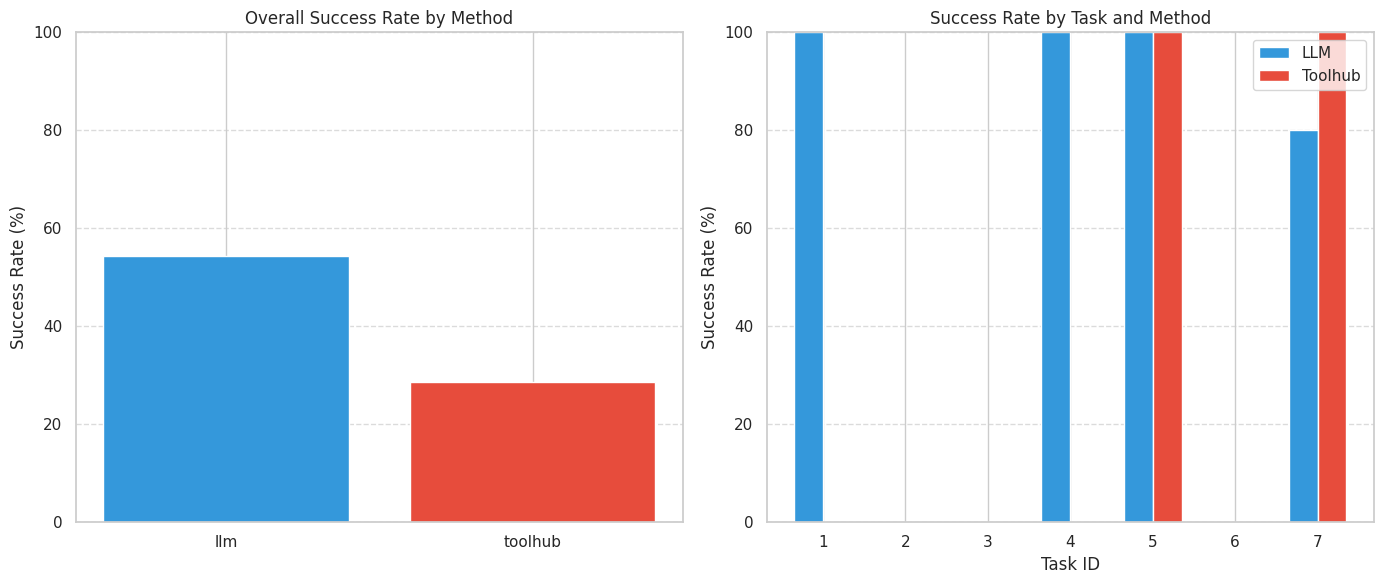

In [7]:
# Load results
df = pd.read_csv("experiment_results.csv")
print(f"Loaded {len(df)} results from CSV")
if 'method' in df.columns:
    print(f"Methods: {df['method'].value_counts().to_dict()}")

# 1. Success Rate Comparison: LLM vs Toolhub
if not df.empty and 'method' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Overall success rate by method
    method_success = df.groupby('method')['status'].apply(lambda x: (x == 'PASS').sum() / len(x) * 100)
    axes[0].bar(method_success.index, method_success.values, color=['#3498db', '#e74c3c'])
    axes[0].set_title('Overall Success Rate by Method')
    axes[0].set_ylabel('Success Rate (%)')
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Success rate by task and method
    task_method_success = df.groupby(['task_id', 'method'])['status'].apply(lambda x: (x == 'PASS').sum() / len(x) * 100).reset_index()
    task_method_success_pivot = task_method_success.pivot(index='task_id', columns='method', values='status')
    
    x = np.arange(len(task_method_success_pivot.index))
    width = 0.35
    axes[1].bar(x - width/2, task_method_success_pivot.get('llm', [0]*len(x)), width, label='LLM', color='#3498db')
    axes[1].bar(x + width/2, task_method_success_pivot.get('toolhub', [0]*len(x)), width, label='Toolhub', color='#e74c3c')
    axes[1].set_xlabel('Task ID')
    axes[1].set_ylabel('Success Rate (%)')
    axes[1].set_title('Success Rate by Task and Method')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(task_method_success_pivot.index)
    axes[1].legend()
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No method column found. Make sure experiment has run with both methods.")


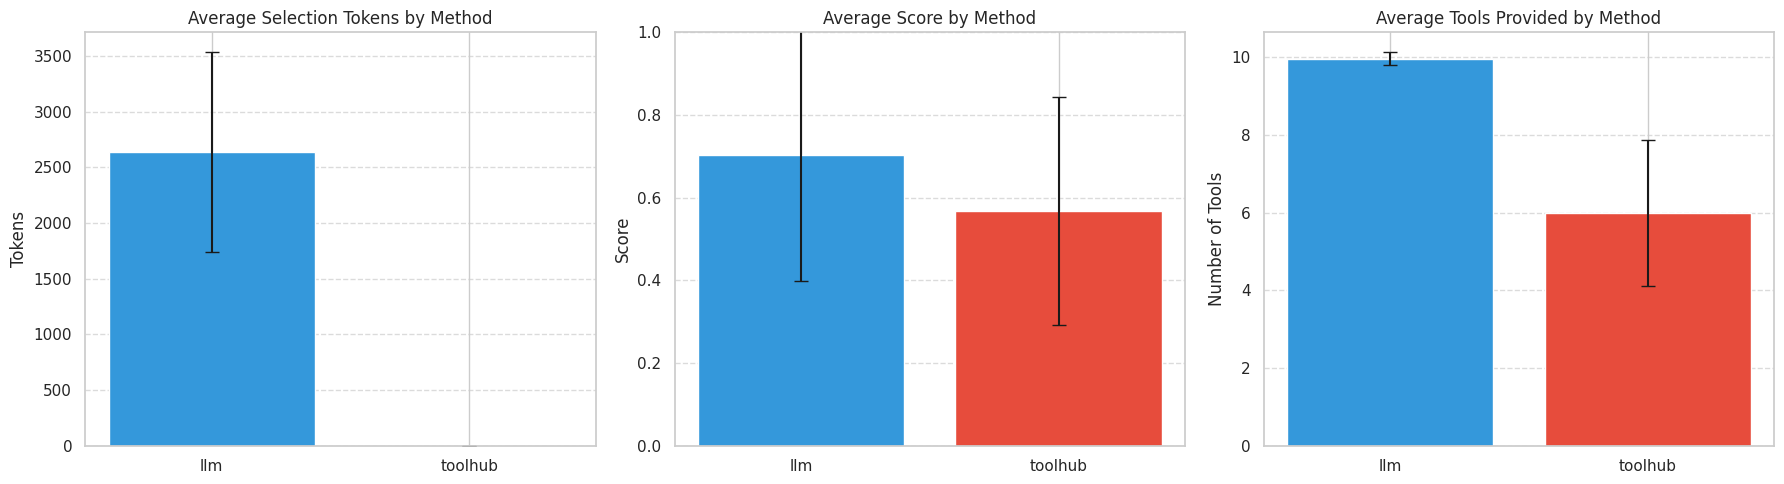

In [8]:
# 2. Token Usage Comparison
if not df.empty and 'method' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Selection tokens
    if 'selection_input_tokens' in df.columns and 'selection_output_tokens' in df.columns:
        df['total_selection_tokens'] = df['selection_input_tokens'] + df['selection_output_tokens']
        selection_tokens_by_method = df.groupby('method')['total_selection_tokens'].agg(['mean', 'std'])
        
        axes[0].bar(selection_tokens_by_method.index, selection_tokens_by_method['mean'], 
                   yerr=selection_tokens_by_method['std'], capsize=5, color=['#3498db', '#e74c3c'])
        axes[0].set_title('Average Selection Tokens by Method')
        axes[0].set_ylabel('Tokens')
        axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Average score by method
    if 'score' in df.columns:
        score_by_method = df.groupby('method')['score'].agg(['mean', 'std'])
        axes[1].bar(score_by_method.index, score_by_method['mean'], 
                   yerr=score_by_method['std'], capsize=5, color=['#3498db', '#e74c3c'])
        axes[1].set_title('Average Score by Method')
        axes[1].set_ylabel('Score')
        axes[1].set_ylim(0, 1)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Tools provided comparison
    if 'tools_provided' in df.columns:
        tools_by_method = df.groupby('method')['tools_provided'].agg(['mean', 'std'])
        axes[2].bar(tools_by_method.index, tools_by_method['mean'], 
                   yerr=tools_by_method['std'], capsize=5, color=['#3498db', '#e74c3c'])
        axes[2].set_title('Average Tools Provided by Method')
        axes[2].set_ylabel('Number of Tools')
        axes[2].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No method column found.")


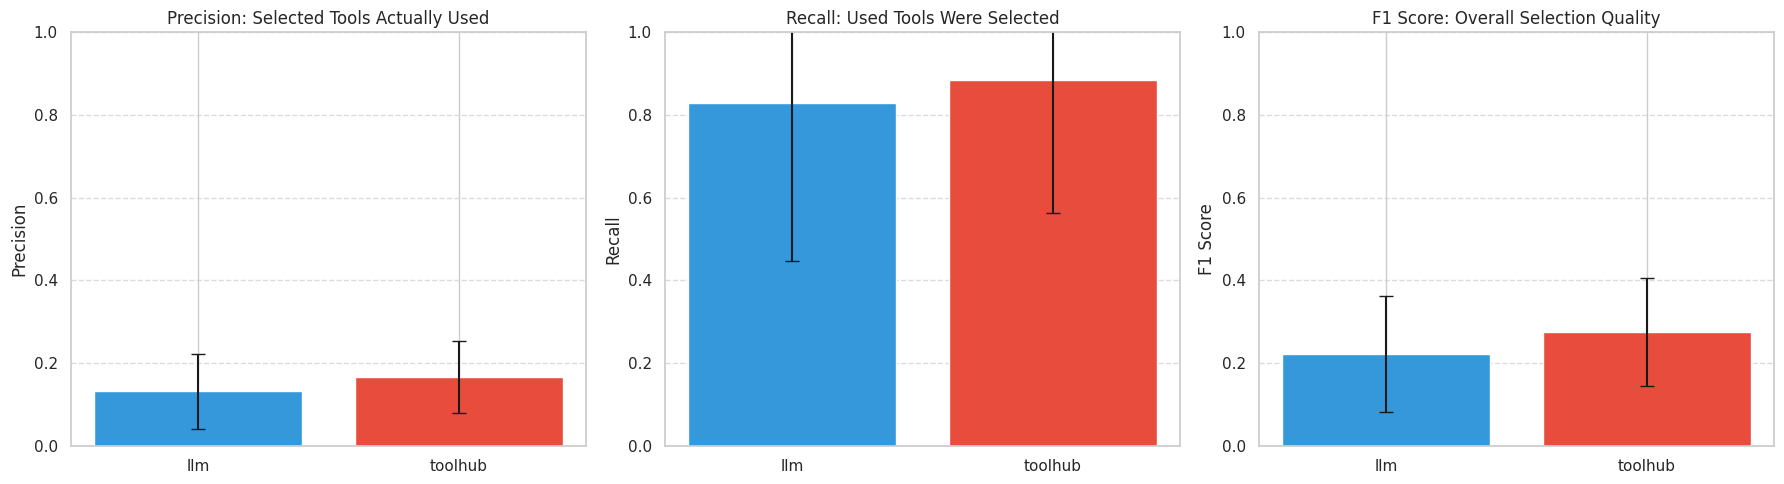


=== Tool Selection Quality Summary ===
        precision              recall                  f1          
             mean       std      mean       std      mean       std
method                                                             
llm      0.131746  0.089910  0.828571  0.382385  0.222098  0.139482
toolhub  0.166327  0.087059  0.885714  0.322803  0.275760  0.131153


In [9]:
# 3. Tool Selection Quality Analysis
if not df.empty and 'method' in df.columns and 'tool_calls' in df.columns:
    # Analyze which tools were actually used vs selected
    from ast import literal_eval
    
    def parse_tool_calls(tool_calls_str):
        """Parse tool_calls string to list."""
        if pd.isna(tool_calls_str):
            return []
        if isinstance(tool_calls_str, str):
            try:
                return literal_eval(tool_calls_str)
            except:
                return []
        return tool_calls_str if isinstance(tool_calls_str, list) else []
    
    df['tool_calls_list'] = df['tool_calls'].apply(parse_tool_calls)
    
    # Calculate precision and recall for each method
    results_analysis = []
    for method in df['method'].unique():
        method_df = df[df['method'] == method]
        
        for idx, row in method_df.iterrows():
            selected = set(parse_tool_calls(row.get('selected_tools', '[]')))
            used = set(row['tool_calls_list'])
            
            if len(selected) > 0:
                precision = len(used & selected) / len(selected)
            else:
                precision = 0
            
            if len(used) > 0:
                recall = len(used & selected) / len(used)
            else:
                recall = 0
            
            results_analysis.append({
                'method': method,
                'task_id': row['task_id'],
                'precision': precision,
                'recall': recall,
                'f1': 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0,
                'selected_count': len(selected),
                'used_count': len(used),
                'overlap': len(used & selected)
            })
    
    analysis_df = pd.DataFrame(results_analysis)
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Precision by method
    precision_by_method = analysis_df.groupby('method')['precision'].agg(['mean', 'std'])
    axes[0].bar(precision_by_method.index, precision_by_method['mean'], 
               yerr=precision_by_method['std'], capsize=5, color=['#3498db', '#e74c3c'])
    axes[0].set_title('Precision: Selected Tools Actually Used')
    axes[0].set_ylabel('Precision')
    axes[0].set_ylim(0, 1)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Recall by method
    recall_by_method = analysis_df.groupby('method')['recall'].agg(['mean', 'std'])
    axes[1].bar(recall_by_method.index, recall_by_method['mean'], 
               yerr=recall_by_method['std'], capsize=5, color=['#3498db', '#e74c3c'])
    axes[1].set_title('Recall: Used Tools Were Selected')
    axes[1].set_ylabel('Recall')
    axes[1].set_ylim(0, 1)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # F1 Score by method
    f1_by_method = analysis_df.groupby('method')['f1'].agg(['mean', 'std'])
    axes[2].bar(f1_by_method.index, f1_by_method['mean'], 
               yerr=f1_by_method['std'], capsize=5, color=['#3498db', '#e74c3c'])
    axes[2].set_title('F1 Score: Overall Selection Quality')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_ylim(0, 1)
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Tool Selection Quality Summary ===")
    print(analysis_df.groupby('method')[['precision', 'recall', 'f1']].agg(['mean', 'std']))
else:
    print("⚠️ Missing required columns for tool selection analysis.")


## Summary Analysis & Conclusions

Compare LLM vs Toolhub performance across all metrics.


EXPERIMENT SUMMARY: LLM vs TOOLHUB

📊 Overall Performance Metrics:
            status     score           tools_provided            \
          <lambda>      mean       std           mean       std   
method                                                            
llm      54.285714  0.704286  0.304711       9.971429  0.169031   
toolhub  28.571429  0.567143  0.275452       6.000000  1.878673   

        tool_calls_count           confabulation total_selection_tokens  \
                    mean       std      <lambda>                   mean   
method                                                                    
llm             1.514286  1.010865           0.0            2637.257143   
toolhub         1.142857  0.733359           0.0               0.000000   

                     
                std  
method               
llm      897.373368  
toolhub    0.000000  


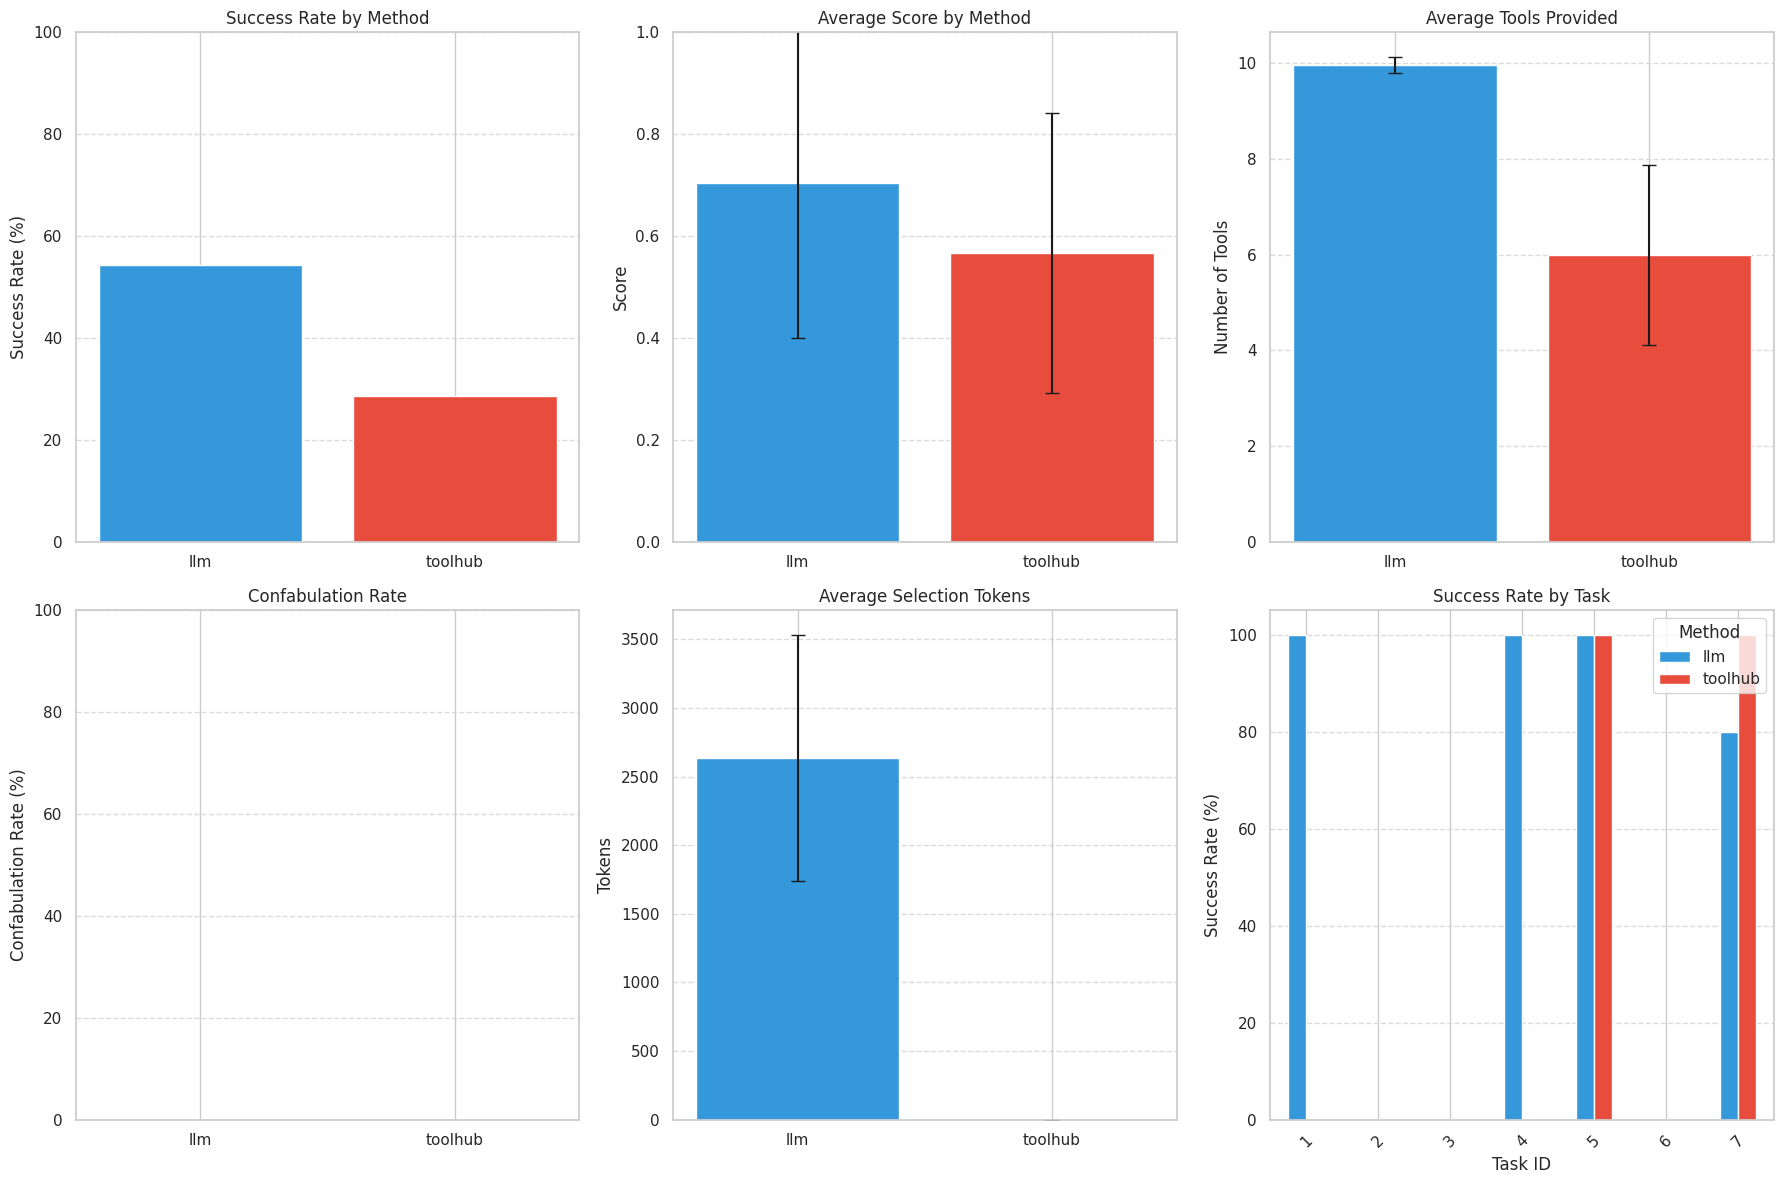


🔍 Missing Tools Analysis:
        missing_count        
                 mean max sum
method                       
llm               0.0   0   0
toolhub           0.0   0   0



In [13]:
# Comprehensive Comparison Summary
if not df.empty and 'method' in df.columns:
    print("=" * 60)
    print("EXPERIMENT SUMMARY: LLM vs TOOLHUB")
    print("=" * 60)
    
    # Overall statistics by method
    summary_stats = df.groupby('method').agg({
        'status': lambda x: (x == 'PASS').sum() / len(x) * 100,
        'score': ['mean', 'std'],
        'tools_provided': ['mean', 'std'],
        'tool_calls_count': ['mean', 'std'],
        'confabulation': lambda x: x.sum() / len(x) * 100,
    })
    
    if 'selection_input_tokens' in df.columns:
        df['total_selection_tokens'] = df['selection_input_tokens'] + df['selection_output_tokens']
        # Merge token statistics properly (it returns a DataFrame with 'mean' and 'std' columns)
        token_stats = df.groupby('method')['total_selection_tokens'].agg(['mean', 'std'])
        # Flatten column names and add to summary_stats
        summary_stats[('total_selection_tokens', 'mean')] = token_stats['mean']
        summary_stats[('total_selection_tokens', 'std')] = token_stats['std']
    
    print("\n📊 Overall Performance Metrics:")
    print(summary_stats)
    
    # Create comprehensive comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Success Rate
    success_rates = df.groupby('method')['status'].apply(lambda x: (x == 'PASS').sum() / len(x) * 100)
    axes[0, 0].bar(success_rates.index, success_rates.values, color=['#3498db', '#e74c3c'])
    axes[0, 0].set_title('Success Rate by Method')
    axes[0, 0].set_ylabel('Success Rate (%)')
    axes[0, 0].set_ylim(0, 100)
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 2. Average Score
    score_stats = df.groupby('method')['score'].agg(['mean', 'std'])
    axes[0, 1].bar(score_stats.index, score_stats['mean'], 
                   yerr=score_stats['std'], capsize=5, color=['#3498db', '#e74c3c'])
    axes[0, 1].set_title('Average Score by Method')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 3. Tools Provided
    tools_stats = df.groupby('method')['tools_provided'].agg(['mean', 'std'])
    axes[0, 2].bar(tools_stats.index, tools_stats['mean'], 
                   yerr=tools_stats['std'], capsize=5, color=['#3498db', '#e74c3c'])
    axes[0, 2].set_title('Average Tools Provided')
    axes[0, 2].set_ylabel('Number of Tools')
    axes[0, 2].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 4. Confabulation Rate
    confab_rates = df.groupby('method')['confabulation'].apply(lambda x: x.sum() / len(x) * 100)
    axes[1, 0].bar(confab_rates.index, confab_rates.values, color=['#3498db', '#e74c3c'])
    axes[1, 0].set_title('Confabulation Rate')
    axes[1, 0].set_ylabel('Confabulation Rate (%)')
    axes[1, 0].set_ylim(0, max(100, confab_rates.max() * 1.1))
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 5. Token Usage (if available)
    if 'total_selection_tokens' in df.columns:
        token_stats = df.groupby('method')['total_selection_tokens'].agg(['mean', 'std'])
        axes[1, 1].bar(token_stats.index, token_stats['mean'], 
                       yerr=token_stats['std'], capsize=5, color=['#3498db', '#e74c3c'])
        axes[1, 1].set_title('Average Selection Tokens')
        axes[1, 1].set_ylabel('Tokens')
        axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
    else:
        axes[1, 1].text(0.5, 0.5, 'Token data\nnot available', 
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Token Usage')
    
    # 6. Task Success Distribution
    task_success = df.groupby(['task_id', 'method'])['status'].apply(lambda x: (x == 'PASS').sum() / len(x) * 100).unstack()
    task_success.plot(kind='bar', ax=axes[1, 2], color=['#3498db', '#e74c3c'])
    axes[1, 2].set_title('Success Rate by Task')
    axes[1, 2].set_ylabel('Success Rate (%)')
    axes[1, 2].set_xlabel('Task ID')
    axes[1, 2].legend(title='Method')
    axes[1, 2].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Missing tools analysis
    print("\n🔍 Missing Tools Analysis:")
    from ast import literal_eval
    
    def parse_list_field(field_str):
        if pd.isna(field_str):
            return []
        if isinstance(field_str, str):
            try:
                return literal_eval(field_str)
            except:
                return []
        return field_str if isinstance(field_str, list) else []
    
    missing_analysis = []
    for method in df['method'].unique():
        method_df = df[df['method'] == method]
        for idx, row in method_df.iterrows():
            selected = set(parse_list_field(row.get('selected_tools', '[]')))
            used = set(parse_list_field(row.get('tool_calls', '[]')))
            missing = used - selected
            
            missing_analysis.append({
                'method': method,
                'task_id': row['task_id'],
                'missing_count': len(missing),
                'missing_tools': list(missing)
            })
    
    missing_df = pd.DataFrame(missing_analysis)
    if not missing_df.empty:
        missing_summary = missing_df.groupby('method').agg({
            'missing_count': ['mean', 'max', 'sum']
        })
        print(missing_summary)
        
        # Show tasks with missing tools
        tasks_with_missing = missing_df[missing_df['missing_count'] > 0]
        if not tasks_with_missing.empty:
            print("\n⚠️ Tasks with missing tools:")
            for idx, row in tasks_with_missing.iterrows():
                print(f"  {row['method']} - Task {row['task_id']}: Missing {row['missing_tools']}")
    
    print("\n" + "=" * 60)
else:
    print("⚠️ No data available for summary. Run the experiment first.")



📋 Task-by-Task Detailed Comparison:

Task 1: Port a table present in Google Docs to Google Sheets. Docume...
  LLM:
    Success Rate: 100.0%
    Avg Score: 0.98
    Avg Tools Provided: 10.0
    Avg Selection Tokens: 3546
  TOOLHUB:
    Success Rate: 0.0%
    Avg Score: 0.33
    Avg Tools Provided: 6.0
    Avg Selection Tokens: 0

Task 2: create an asana ticket in asana workspace ID 121192840512297...
  LLM:
    Success Rate: 0.0%
    Avg Score: 0.52
    Avg Tools Provided: 10.0
    Avg Selection Tokens: 2830
  TOOLHUB:
    Success Rate: 0.0%
    Avg Score: 0.58
    Avg Tools Provided: 7.0
    Avg Selection Tokens: 0

Task 3: push the latest changes in https://github.com/seer-engg/bugg...
  LLM:
    Success Rate: 0.0%
    Avg Score: 0.38
    Avg Tools Provided: 10.0
    Avg Selection Tokens: 3360
  TOOLHUB:
    Success Rate: 0.0%
    Avg Score: 0.33
    Avg Tools Provided: 3.0
    Avg Selection Tokens: 0

Task 4: find akshay@getseer.dev's google calendar events for next da...
  LLM:
  

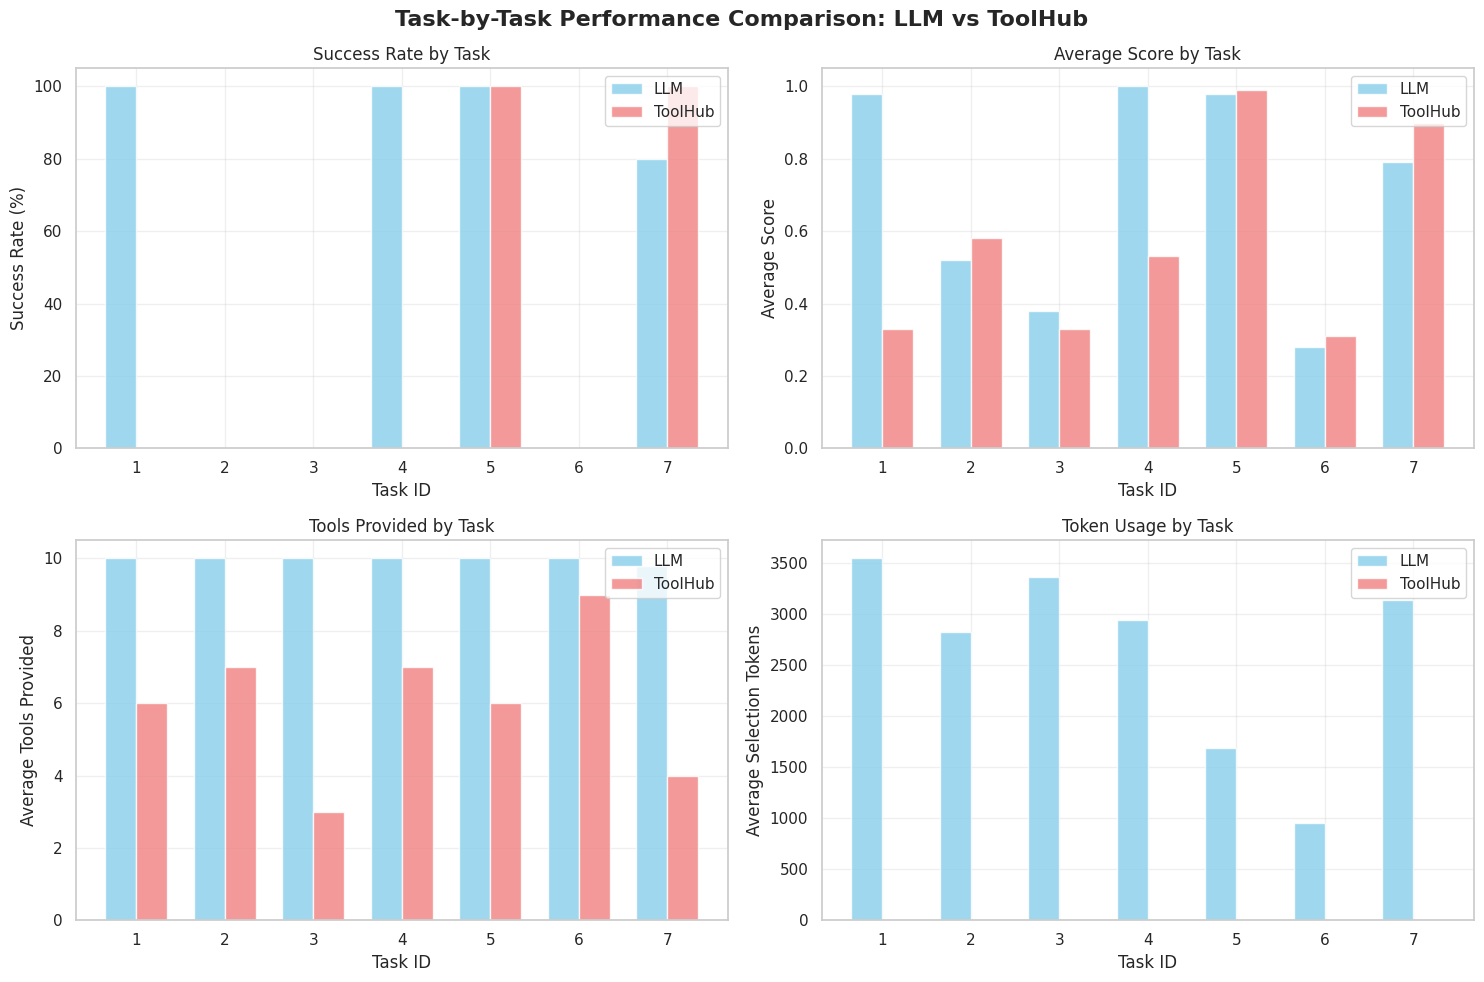

In [14]:
# Additional Analysis: Detailed Task-by-Task Comparison with Visualization
if not df.empty and 'method' in df.columns:
    print("\n📋 Task-by-Task Detailed Comparison:")
    print("=" * 60)
    
    # Collect data for plotting
    task_comparison_data = []
    
    for task_id in sorted(df['task_id'].unique()):
        task_df = df[df['task_id'] == task_id]
        print(f"\nTask {task_id}: {TASKS[task_id-1]['instruction'][:60]}...")
        
        task_data = {'task_id': task_id}
        
        for method in ['llm', 'toolhub']:
            method_task_df = task_df[task_df['method'] == method]
            if not method_task_df.empty:
                success_rate = (method_task_df['status'] == 'PASS').sum() / len(method_task_df) * 100
                avg_score = method_task_df['score'].mean()
                avg_tools = method_task_df['tools_provided'].mean()
                
                print(f"  {method.upper()}:")
                print(f"    Success Rate: {success_rate:.1f}%")
                print(f"    Avg Score: {avg_score:.2f}")
                print(f"    Avg Tools Provided: {avg_tools:.1f}")
                
                # Store data for plotting
                task_data[f'{method}_success_rate'] = success_rate
                task_data[f'{method}_avg_score'] = avg_score
                task_data[f'{method}_avg_tools'] = avg_tools
                
                if 'total_selection_tokens' in method_task_df.columns:
                    avg_tokens = method_task_df['total_selection_tokens'].mean()
                    print(f"    Avg Selection Tokens: {avg_tokens:.0f}")
                    task_data[f'{method}_avg_tokens'] = avg_tokens
        
        task_comparison_data.append(task_data)
    
    # Create visualization
    if task_comparison_data:
        import matplotlib.pyplot as plt
        import numpy as np
        
        task_comp_df = pd.DataFrame(task_comparison_data)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Task-by-Task Performance Comparison: LLM vs ToolHub', fontsize=16, fontweight='bold')
        
        # Success Rate Comparison
        ax1 = axes[0, 0]
        x = np.arange(len(task_comp_df))
        width = 0.35
        
        llm_success = task_comp_df.get('llm_success_rate', [0] * len(task_comp_df))
        toolhub_success = task_comp_df.get('toolhub_success_rate', [0] * len(task_comp_df))
        
        ax1.bar(x - width/2, llm_success, width, label='LLM', color='skyblue', alpha=0.8)
        ax1.bar(x + width/2, toolhub_success, width, label='ToolHub', color='lightcoral', alpha=0.8)
        ax1.set_xlabel('Task ID')
        ax1.set_ylabel('Success Rate (%)')
        ax1.set_title('Success Rate by Task')
        ax1.set_xticks(x)
        ax1.set_xticklabels(task_comp_df['task_id'])
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Average Score Comparison
        ax2 = axes[0, 1]
        llm_scores = task_comp_df.get('llm_avg_score', [0] * len(task_comp_df))
        toolhub_scores = task_comp_df.get('toolhub_avg_score', [0] * len(task_comp_df))
        
        ax2.bar(x - width/2, llm_scores, width, label='LLM', color='skyblue', alpha=0.8)
        ax2.bar(x + width/2, toolhub_scores, width, label='ToolHub', color='lightcoral', alpha=0.8)
        ax2.set_xlabel('Task ID')
        ax2.set_ylabel('Average Score')
        ax2.set_title('Average Score by Task')
        ax2.set_xticks(x)
        ax2.set_xticklabels(task_comp_df['task_id'])
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Tools Provided Comparison
        ax3 = axes[1, 0]
        llm_tools = task_comp_df.get('llm_avg_tools', [0] * len(task_comp_df))
        toolhub_tools = task_comp_df.get('toolhub_avg_tools', [0] * len(task_comp_df))
        
        ax3.bar(x - width/2, llm_tools, width, label='LLM', color='skyblue', alpha=0.8)
        ax3.bar(x + width/2, toolhub_tools, width, label='ToolHub', color='lightcoral', alpha=0.8)
        ax3.set_xlabel('Task ID')
        ax3.set_ylabel('Average Tools Provided')
        ax3.set_title('Tools Provided by Task')
        ax3.set_xticks(x)
        ax3.set_xticklabels(task_comp_df['task_id'])
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Token Usage Comparison (if available)
        ax4 = axes[1, 1]
        if 'llm_avg_tokens' in task_comp_df.columns or 'toolhub_avg_tokens' in task_comp_df.columns:
            llm_tokens = task_comp_df.get('llm_avg_tokens', [0] * len(task_comp_df))
            toolhub_tokens = task_comp_df.get('toolhub_avg_tokens', [0] * len(task_comp_df))
            
            ax4.bar(x - width/2, llm_tokens, width, label='LLM', color='skyblue', alpha=0.8)
            ax4.bar(x + width/2, toolhub_tokens, width, label='ToolHub', color='lightcoral', alpha=0.8)
            ax4.set_xlabel('Task ID')
            ax4.set_ylabel('Average Selection Tokens')
            ax4.set_title('Token Usage by Task')
            ax4.set_xticks(x)
            ax4.set_xticklabels(task_comp_df['task_id'])
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'Token data not available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Token Usage by Task')
        
        plt.tight_layout()
        plt.show()
        
else:
    print("⚠️ No data available.")

In [ ]:
s